In [1]:
WORKING = 0
CRACK = 1
LCD = 2

CLASS_NUMBERS = [WORKING, CRACK, LCD]
CLASS_NAMES = ["Working", "Crack", "LCD"]

NUM_CLASSES = 3

In [2]:
import os

def collect_file_paths(path: str, ext: str) -> list[str]:
    result = []
    
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            result.extend(collect_file_paths(item_path, ext))
        elif item_path.endswith(ext):
            result.append(item_path)
                
    return result

In [16]:
import cv2
import numpy as np

def images_to_array(image_paths: list[str], shrink_factor: int) -> np.ndarray:
    images = []
    
    for image_file in image_paths:
        image = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
        
        new_size = (
               int(image.shape[1] * shrink_factor / 100),
               int(image.shape[0] * shrink_factor / 100)
        )
        image = cv2.resize(image, dsize = new_size, interpolation = cv2.INTER_AREA)
        images.append(image)
        
    return np.array(images)

In [88]:
file_paths = collect_file_paths("images_for_model", ".jpeg")

input_filepaths = []
labels_list = []

for path in file_paths:
    file_name = path.split("/")[-1]
    labels = file_name.split("_")

    if not ("unknown" in labels):
        if "crack" in labels:
            labels_list.append(CRACK)
        elif "lcd" in labels:
            labels_list.append(LCD)
        else:
            labels_list.append(WORKING)
        input_filepaths.append(path)
        
X = images_to_array(input_filepaths, 20)
y = np.array(labels_list)


ERROR! Session/line number was not unique in database. History logging moved to new session 31


In [89]:
NUM_SAMPLES = X.shape[0]
IMAGE_WIDTH = X.shape[1]
IMAGE_HEIGHT = X.shape[2]
IMAGE_SHAPE = (X.shape[1], X.shape[2], X.shape[3])

print("Entire dataset")
print("--------------")
print("Input shape: ", X.shape)
print("Output shape: ", y.shape)
print("Number of working phones: ", np.sum(y == WORKING))
print("Number of cracked phones: ", np.sum(y == CRACK))
print("Number of phones with damaged lcd: ", np.sum(y == LCD))
print("")

Entire dataset
--------------
Input shape:  (259, 806, 604, 3)
Output shape:  (259,)
Number of working phones:  132
Number of cracked phones:  111
Number of phones with damaged lcd:  16



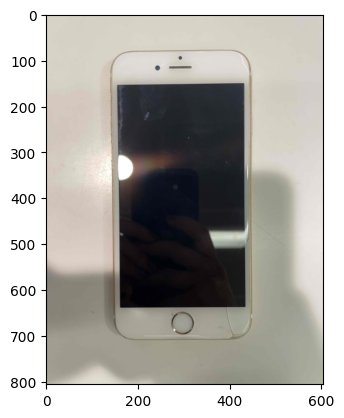

In [25]:
import matplotlib.pyplot as plt
plt.imshow(X[1])
plt.show()

In [90]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

In [91]:
# y_train=y_train.astype(int)
# y_test=y_test.astype(int)

In [92]:
mu = X_train.mean(axis=(0,1,2)) # finds mean of R, G and B separately
std = X_train.std(axis=(0,1,2)) # same for std
X_train_norm = (X_train - mu)/std
X_test_norm = (X_test - mu)/std

In [93]:
class KNearestNeighbor(object):
    def __init__(self):
        pass
    def train(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def predict(self, X, k=1, num_loops=0):
        if num_loops == 0:
            dists = self.compute_distances(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)
        return self.predict_labels(dists, k=k)


    def compute_distances(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train)) 
        dists = np.sqrt(np.sum(np.square(self.X_train), axis=1) + np.sum(np.square(X), axis=1)[:, np.newaxis] - 2 * np.dot(X, self.X_train.T))
        pass
        return dists

    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            sorted_dist = np.argsort(dists[i])
            closest_y = list(self.y_train[sorted_dist[0:k]])  
            pass
            y_pred[i]= np.argmax(np.bincount(closest_y))
            pass
        return y_pred

In [94]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(181, 1460472) (78, 1460472)


In [95]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
dists= classifier.compute_distances(X_test)
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
num_test=X_test.shape[0]
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 38 / 78 correct => accuracy: 0.487179


In [96]:
print(y_test_pred)
print(y_test)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[1 1 0 1 1 1 1 0 0 0 0 1 1 2 0 0 1 1 0 0 0 1 1 1 1 1 0 2 1 2 0 1 1 1 1 0 0
 2 0 1 1 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 2 1 0 1 0 0 1 1 0 1 0 0 0 0 0 2 0 0
 0 0 1 2]


In [102]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

num_neigs=[1,2,3,4,5]
kFold = StratifiedKFold(n_splits = 3, shuffle = True)

confusion_matrices = []
acc = []

for k in num_neigs:
    for train_index, test_index in kFold.split(X, y):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        X_train = np.reshape(X_train, (X_train.shape[0], -1))
        X_test = np.reshape(X_test, (X_test.shape[0], -1))
        
        
        KNN=KNearestNeighbor()
        KNN.train(X_train, y_train)
        dists= KNN.compute_distances(X_test)
        y_test_pred = KNN.predict_labels(dists, k=k)
        num_correct = np.sum(y_test_pred == y_test)
        num_test=X_test.shape[0]
        accuracy = float(num_correct) / num_test
        
        acc.append(accuracy)


    confusion_matrices.append(
        confusion_matrix(y_test, y_test_pred, labels = CLASS_NUMBERS)
    )
    print(f'Mean accuracy for KNN with {k} neighbour(s): {np.mean(acc)}')
    print(classification_report(y_test, y_test_pred, labels = CLASS_NUMBERS, target_names=CLASS_NAMES))
        

Mean accuracy for KNN with 1 neighbour(s): 0.4942684766214178
              precision    recall  f1-score   support

     Working       0.51      1.00      0.68        26
       Crack       0.00      0.00      0.00        22
         LCD       0.00      0.00      0.00         3

    accuracy                           0.51        51
   macro avg       0.17      0.33      0.23        51
weighted avg       0.26      0.51      0.34        51



/gpfs/space/home/kozlovsk/venvs/foxway_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/space/home/kozlovsk/venvs/foxway_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/space/home/kozlovsk/venvs/foxway_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Mean accuracy for KNN with 2 neighbour(s): 0.5019607843137255
              precision    recall  f1-score   support

     Working       0.51      1.00      0.68        26
       Crack       0.00      0.00      0.00        22
         LCD       0.00      0.00      0.00         3

    accuracy                           0.51        51
   macro avg       0.17      0.33      0.23        51
weighted avg       0.26      0.51      0.34        51



/gpfs/space/home/kozlovsk/venvs/foxway_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/space/home/kozlovsk/venvs/foxway_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/space/home/kozlovsk/venvs/foxway_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Mean accuracy for KNN with 3 neighbour(s): 0.504524886877828
              precision    recall  f1-score   support

     Working       0.51      1.00      0.68        26
       Crack       0.00      0.00      0.00        22
         LCD       0.00      0.00      0.00         3

    accuracy                           0.51        51
   macro avg       0.17      0.33      0.23        51
weighted avg       0.26      0.51      0.34        51



/gpfs/space/home/kozlovsk/venvs/foxway_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/space/home/kozlovsk/venvs/foxway_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/space/home/kozlovsk/venvs/foxway_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Mean accuracy for KNN with 4 neighbour(s): 0.5058069381598794
              precision    recall  f1-score   support

     Working       0.51      1.00      0.68        26
       Crack       0.00      0.00      0.00        22
         LCD       0.00      0.00      0.00         3

    accuracy                           0.51        51
   macro avg       0.17      0.33      0.23        51
weighted avg       0.26      0.51      0.34        51



/gpfs/space/home/kozlovsk/venvs/foxway_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/space/home/kozlovsk/venvs/foxway_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/space/home/kozlovsk/venvs/foxway_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Mean accuracy for KNN with 5 neighbour(s): 0.5065761689291101
              precision    recall  f1-score   support

     Working       0.51      1.00      0.68        26
       Crack       0.00      0.00      0.00        22
         LCD       0.00      0.00      0.00         3

    accuracy                           0.51        51
   macro avg       0.17      0.33      0.23        51
weighted avg       0.26      0.51      0.34        51



/gpfs/space/home/kozlovsk/venvs/foxway_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/space/home/kozlovsk/venvs/foxway_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfs/space/home/kozlovsk/venvs/foxway_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Confusion matrix of KNN, k = 1


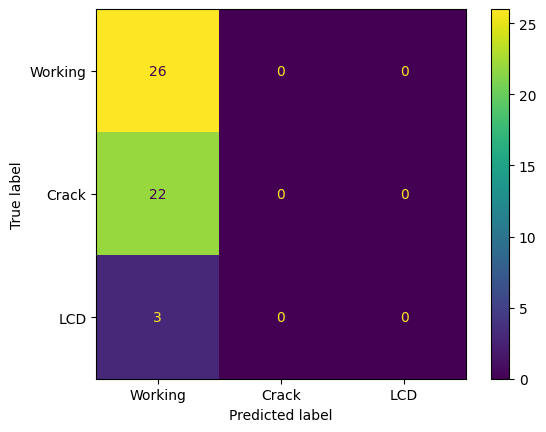

Confusion matrix of KNN, k = 2


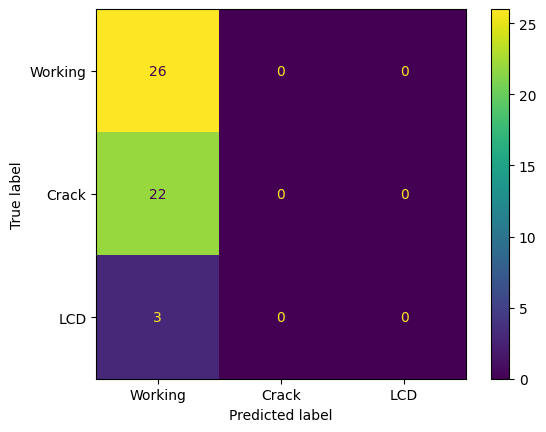

Confusion matrix of KNN, k = 3


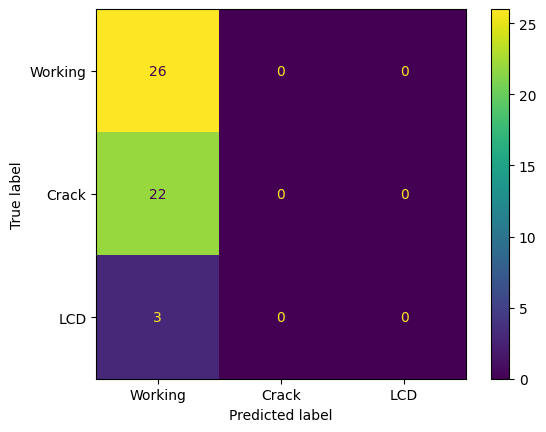

Confusion matrix of KNN, k = 4


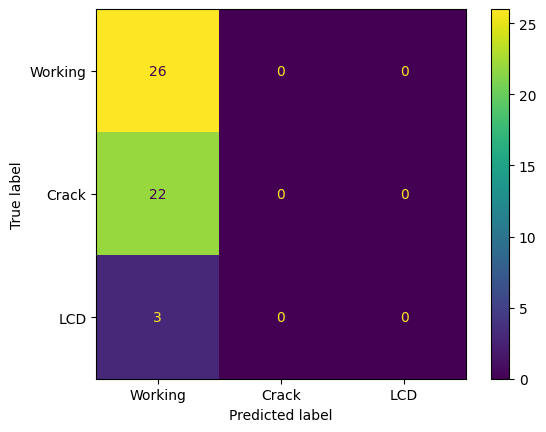

Confusion matrix of KNN, k = 5


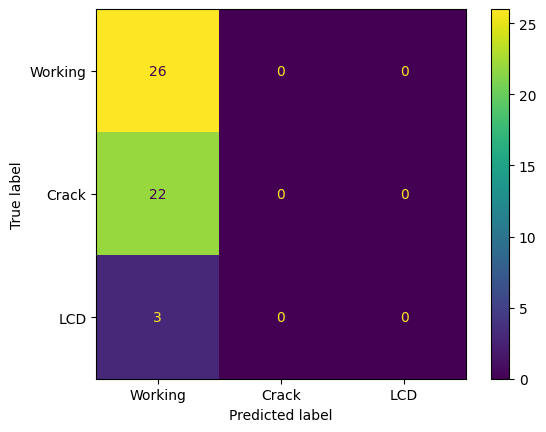

In [106]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for i in num_neigs:
    print(f"Confusion matrix of KNN, k = {i}" )
    
    disp = ConfusionMatrixDisplay(
        confusion_matrix = confusion_matrices[i-1], 
        display_labels = CLASS_NAMES
    )
    disp.plot()
    plt.show()

In [ ]:
# make representation of classes
# make representation of worong classified cases
# make augmentation 